# Analyzing Police Activity with Python


We will be working with dataset of traffic stops by police officers that was collected by Standard Open Policing Project. 
They have collected data from 31 US states here we will be focusing on data from the state of Rhode Island.

[Source of the data](https://openpolicing.stanford.edu/)

## Importing libraries and datasets


In [1]:
import matplotlib.pyplot as plt
import pandas as pd


# Import the  datasets 
police = pd.read_csv('datasets/police.csv')
weather = pd.read_csv('datasets/weather.csv')

## Examing & Preparing the dataset

In [2]:
print(police.head())

print(police.isnull().sum())

  state   stop_date stop_time  ...  stop_duration drugs_related_stop district
0    RI  2005-01-04     12:55  ...       0-15 Min              False  Zone X4
1    RI  2005-01-23     23:15  ...       0-15 Min              False  Zone K3
2    RI  2005-02-17     04:15  ...       0-15 Min              False  Zone X4
3    RI  2005-02-20     17:15  ...      16-30 Min              False  Zone X1
4    RI  2005-02-24     01:20  ...       0-15 Min              False  Zone X3

[5 rows x 15 columns]
state                     0
stop_date                 0
stop_time                 0
county_name           91741
driver_gender          5205
driver_race            5202
violation_raw          5202
violation              5202
search_conducted          0
search_type           88434
stop_outcome           5202
is_arrested            5202
stop_duration          5202
drugs_related_stop        0
district                  0
dtype: int64


Looks like most of the columns have at least some missing values.

### Dropping columns

We'll drop the county_name column because it only contains missing values, and the state column because all of the traffic stops took place in one state (Rhode Island).

In [3]:
print(police.shape)

police.drop(['county_name', 'state'], axis='columns', inplace=True)

print(police.shape)

(91741, 15)
(91741, 13)


### Dropping rows

The driver_gender column will be critical to many of your analyses. Because only a small fraction of rows are missing driver_gender, we'll drop those rows from the dataset

In [4]:
police.dropna(subset=['driver_gender'], inplace=True)

print(police.isnull().sum())

print(police.shape)

stop_date                 0
stop_time                 0
driver_gender             0
driver_race               0
violation_raw             0
violation                 0
search_conducted          0
search_type           83229
stop_outcome              0
is_arrested               0
stop_duration             0
drugs_related_stop        0
district                  0
dtype: int64
(86536, 13)


We dropped around 5,000 rows, which is a small fraction of the dataset, and now only one column(serach_type) remains with any missing values.

### Fixing a data type

In [5]:
police.dtypes

stop_date             object
stop_time             object
driver_gender         object
driver_race           object
violation_raw         object
violation             object
search_conducted        bool
search_type           object
stop_outcome          object
is_arrested           object
stop_duration         object
drugs_related_stop      bool
district              object
dtype: object

is_arrested column contains True and False values and the column currently has object datatype. So we'll chnage the data type to bool.

In [6]:
police['is_arrested'] = police.is_arrested.astype('bool')


### Creating DateTime Index

In [7]:
combined = police.stop_date.str.cat(police.stop_time,sep=' ')

police['stop_datetime'] = pd.to_datetime(combined)

print(police.dtypes)

stop_date                     object
stop_time                     object
driver_gender                 object
driver_race                   object
violation_raw                 object
violation                     object
search_conducted                bool
search_type                   object
stop_outcome                  object
is_arrested                     bool
stop_duration                 object
drugs_related_stop              bool
district                      object
stop_datetime         datetime64[ns]
dtype: object


In [8]:
police.set_index('stop_datetime',inplace = True)

print(police.index)

print(police.columns)

DatetimeIndex(['2005-01-04 12:55:00', '2005-01-23 23:15:00',
               '2005-02-17 04:15:00', '2005-02-20 17:15:00',
               '2005-02-24 01:20:00', '2005-03-14 10:00:00',
               '2005-03-29 21:55:00', '2005-04-04 21:25:00',
               '2005-07-14 11:20:00', '2005-07-14 19:55:00',
               ...
               '2015-12-31 13:23:00', '2015-12-31 18:59:00',
               '2015-12-31 19:13:00', '2015-12-31 20:20:00',
               '2015-12-31 20:50:00', '2015-12-31 21:21:00',
               '2015-12-31 21:59:00', '2015-12-31 22:04:00',
               '2015-12-31 22:09:00', '2015-12-31 22:47:00'],
              dtype='datetime64[ns]', name='stop_datetime', length=86536, freq=None)
Index(['stop_date', 'stop_time', 'driver_gender', 'driver_race',
       'violation_raw', 'violation', 'search_conducted', 'search_type',
       'stop_outcome', 'is_arrested', 'stop_duration', 'drugs_related_stop',
       'district'],
      dtype='object')


## Relationship between Gender and Policing

### Do different genders tend to commit different types of traffic violations?

Before comparing the violations being committed by each gender, we should examine the violations committed by all drivers to get a baseline understanding of the data.

In [9]:
print(police.violation.value_counts())
print('\n')
print(police.violation.value_counts(normalize=True))

Speeding               48423
Moving violation       16224
Equipment              10921
Other                   4409
Registration/plates     3703
Seat belt               2856
Name: violation, dtype: int64


Speeding               0.559571
Moving violation       0.187483
Equipment              0.126202
Other                  0.050950
Registration/plates    0.042791
Seat belt              0.033004
Name: violation, dtype: float64


More than half of all violations are for speeding, followed by other moving violations and equipment violations.

In [10]:
female = police[police.driver_gender=='F']

male = police[police.driver_gender=='M']

print(female.violation.value_counts(normalize=True))
print('\n')
print(male.violation.value_counts(normalize=True))

Speeding               0.658114
Moving violation       0.138218
Equipment              0.105199
Registration/plates    0.044418
Other                  0.029738
Seat belt              0.024312
Name: violation, dtype: float64


Speeding               0.522243
Moving violation       0.206144
Equipment              0.134158
Other                  0.058985
Registration/plates    0.042175
Seat belt              0.036296
Name: violation, dtype: float64


About two-thirds of female traffic stops are for speeding, whereas stops of males are more balanced among the six categories. This doesn't mean that females speed more often than males, however, since we didn't take into account the number of stops or drivers.

### Does gender affect who gets a ticket for speeding?

When a driver is pulled over for speeding, many people believe that gender has an impact on whether the driver will receive a ticket or a warning. Lets check!

In [11]:
female_and_speeding = police[(police.driver_gender=='F') & (police.violation=='Speeding')]

male_and_speeding = police[(police.driver_gender=='M') & (police.violation=='Speeding')]

print(female_and_speeding.stop_outcome.value_counts(normalize=True))
print('\n')
print(male_and_speeding.stop_outcome.value_counts(normalize=True))

Citation            0.952192
Warning             0.040074
Arrest Driver       0.005752
N/D                 0.000959
Arrest Passenger    0.000639
No Action           0.000383
Name: stop_outcome, dtype: float64


Citation            0.944595
Warning             0.036184
Arrest Driver       0.015895
Arrest Passenger    0.001281
No Action           0.001068
N/D                 0.000976
Name: stop_outcome, dtype: float64


The numbers are similar for males and females: about 95% of stops for speeding result in a ticket. Thus, the data fails to show that gender has an impact on who gets a ticket for speeding.

### Does gender affect whose vehicle is searched?

In [12]:
#search rate
print(police.search_conducted.mean())

0.0382153092354627


It looks like the search rate is about 3.8%.

Comparing the rates at which female and male drivers are searched during a traffic stop

In [13]:
print(police.groupby('driver_gender').search_conducted.mean())

driver_gender
F    0.019181
M    0.045426
Name: search_conducted, dtype: float64


Male drivers are searched more than twice as often as female drivers. Why??

it's possible that the difference is mostly due to a second factor.

For example, you might hypothesize that the search rate varies by violation type, and the difference in search rate between males and females is because they tend to commit different violations. Let's see..

In [14]:
print(police.groupby(['driver_gender','violation']).search_conducted.mean())

driver_gender  violation          
F              Equipment              0.039984
               Moving violation       0.039257
               Other                  0.041018
               Registration/plates    0.054924
               Seat belt              0.017301
               Speeding               0.008309
M              Equipment              0.071496
               Moving violation       0.061524
               Other                  0.046191
               Registration/plates    0.108802
               Seat belt              0.035119
               Speeding               0.027885
Name: search_conducted, dtype: float64


For all types of violations, the search rate is higher for males than for females, disproving our hypothesis

### Does gender affect who is frisked during a search?

During a vehicle search, the police officer may pat down the driver to check if they have a weapon. This is known as a "protective frisk."

We'll check all instances in which the driver was frisked

In [15]:
police.search_type.value_counts()

Incident to Arrest                                          1290
Probable Cause                                               924
Inventory                                                    219
Reasonable Suspicion                                         214
Protective Frisk                                             164
Incident to Arrest,Inventory                                 123
Incident to Arrest,Probable Cause                            100
Probable Cause,Reasonable Suspicion                           54
Incident to Arrest,Inventory,Probable Cause                   35
Probable Cause,Protective Frisk                               35
Incident to Arrest,Protective Frisk                           33
Inventory,Probable Cause                                      25
Protective Frisk,Reasonable Suspicion                         19
Incident to Arrest,Inventory,Protective Frisk                 18
Incident to Arrest,Probable Cause,Protective Frisk            13
Inventory,Protective Fris

Protective Frisk 164 times was only the search type

In [16]:
police['frisk'] = police.search_type.str.contains('Protective Frisk', na=False)

print(police.frisk.dtype)

print(police.frisk.sum())

bool
303


 It looks like there were 303 drivers who were frisked.

In [17]:
searched = police[police.search_conducted == True]

print(searched.frisk.mean())

print(searched.groupby('driver_gender').frisk.mean())

0.09162382824312065
driver_gender
F    0.074561
M    0.094353
Name: frisk, dtype: float64


The frisk rate is higher for males than for females, though we can't conclude that this difference is caused by the driver's gender.

## Visual EDA

### Does time of day affect arrest rate?

In [18]:
print(police.is_arrested.mean())

hourly_arrest_rate = police.groupby(police.index.hour).is_arrested.mean()


0.0355690117407784


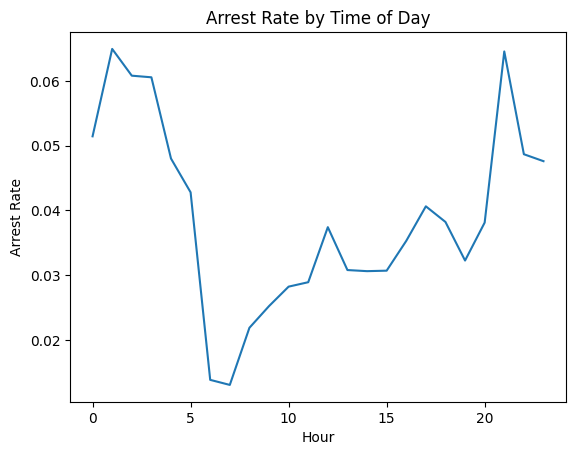

In [19]:
hourly_arrest_rate.plot()

plt.xlabel('Hour')
plt.ylabel('Arrest Rate')
plt.title('Arrest Rate by Time of Day')

plt.show()

The arrest rate has a significant spike overnight, and then dips in the early morning hours.

### Are drug-related stops on the rise?

Here we will calculate rate annual drug related stops by resampling and visualize how the rate has changed over time.

Note: Resampling is when you change the frequency of your time series observations.

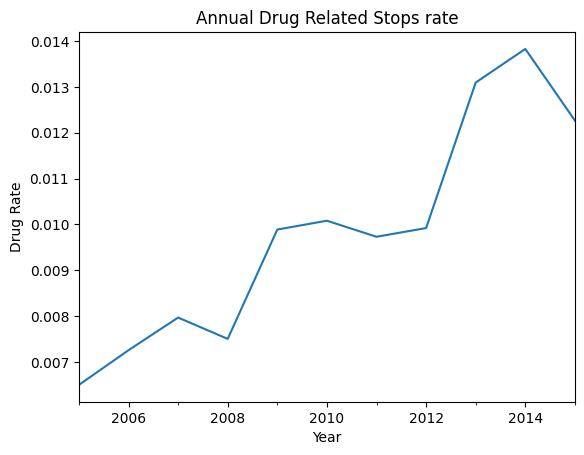

In [20]:
annual_drug_rate = police.drugs_related_stop.resample('A').mean()

annual_drug_rate.plot()

plt.xlabel('Year')
plt.ylabel('Drug Rate')
plt.title('Annual Drug Related Stops rate')

plt.show()

The rate of drug-related stops nearly doubled over the course of 10 years. Why might that be the case?

We might hypothesize that the rate of vehicle searches was also increasing, which would have led to an increase in drug-related stops even if more drivers were not carrying drugs.

Comparing drug and search rates:

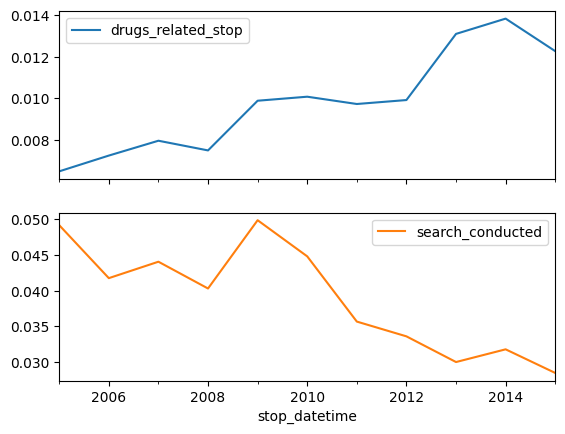

In [21]:
annual_search_rate = police.search_conducted.resample('A').mean()

annual = pd.concat([annual_drug_rate,annual_search_rate], axis='columns')

annual.plot(subplots=True)

plt.show()

The rate of drug-related stops increased even though the search rate decreased, disproving our hypothesis.

### What violations are caught in each district?

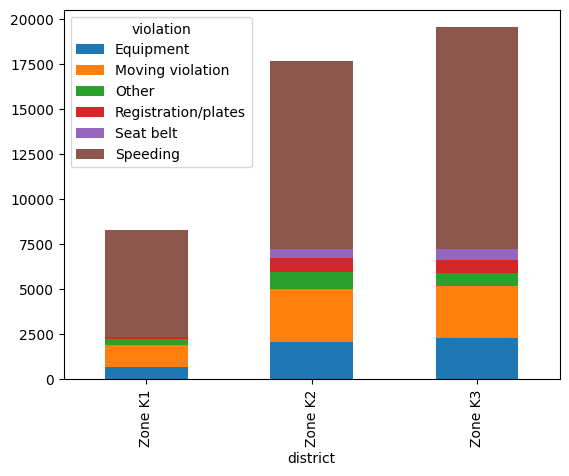

In [22]:
all_zones = pd.crosstab(police.district,police.violation)

# lets focus on 'K' zones.
k_zones = all_zones.loc['Zone K1':'Zone K3']

k_zones.plot(kind='bar',stacked=True)

plt.show()

 The vast majority of traffic stops in Zone K1 are for speeding, and Zones K2 and K3 are remarkably similar to one another in terms of violations.

### How long might you be stopped for a violation?

In [23]:
police.stop_duration.unique()

array(['0-15 Min', '16-30 Min', '30+ Min'], dtype=object)

In the traffic stops dataset, the stop_duration column tells you approximately how long the driver was detained by the officer. Unfortunately, the durations are stored as strings, such as '0-15 Min'.

We'll convert the stop durations to integers. Because the precise durations are not available, you'll have to estimate the numbers using reasonable values:

Convert '0-15 Min' to 8

Convert '16-30 Min' to 23

Convert '30+ Min' to 45

In [24]:
mapping = {'0-15 Min':8,'16-30 Min':23,'30+ Min':45}

police['stop_minutes'] = police.stop_duration.map(mapping)

print(police.stop_minutes.unique())

[ 8 23 45]


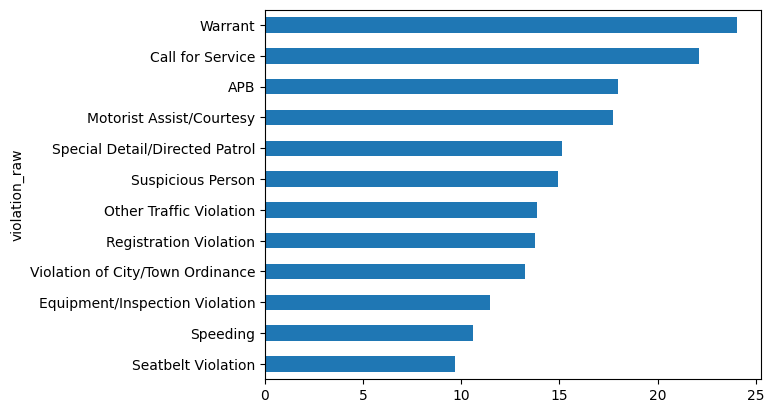

In [25]:
stop_length = police.groupby('violation_raw').stop_minutes.mean()

stop_length.sort_values().plot(kind='barh')

plt.show()

Looks like on an average the stop time for Warrant and Call for Service is more than 20 min.

## Analyzing the effect of weather on policing

Now we'll be exploring a new dataset to determine if weather conditions have an impact on police behavior. The weather data was collected by the National Centers for Environmental Information. 

Our hypothesis is that weather conditions impact police behavior during traffic stops, so ideally we would look up the historical weather at the location of each stop. However, the traffic stops dataset does not specify stop location, so we're going to use the data from a single weather station near the center of Rhode Island. This is not ideal, but Rhode Island is the smallest US state and so a single station will still give us a general idea of the weather throughout the state.

### Exploring the weather dataset

In [26]:
weather.head()

,STATION,DATE,TAVG,TMIN,TMAX,AWND,WSF2,WT01,WT02,WT03,WT04,WT05,WT06,WT07,WT08,WT09,WT10,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22
0,USW00014765,2005-01-01,44.0,35,53,8.95,25.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00014765,2005-01-02,36.0,28,44,9.40,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
2,USW00014765,2005-01-03,49.0,44,53,6.93,17.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,USW00014765,2005-01-04,42.0,39,45,6.93,16.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,USW00014765,2005-01-05,36.0,28,43,7.83,17.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN


We can see that the station column lists the station ID, and there's one row for each date. There are three columns related to temperature, two columns related to wind speed, and 20 columns related to the presence of certain bad weather conditions.

let's look at the two columns related to wind speed. 

AWND is average wind speed in miles per hour, and WSF2 is the fastest 2-minute wind speed, meaning the fastest wind speed during any 2-minute period. 

In [27]:
weather[['AWND','WSF2']].describe()

,AWND,WSF2
count,4017.000000,4017.000000
mean,8.593707,19.274782
std,3.364601,5.623866
min,0.220000,4.900000
25%,6.260000,15.000000
50%,8.050000,17.900000
75%,10.290000,21.900000
max,26.840000,48.100000


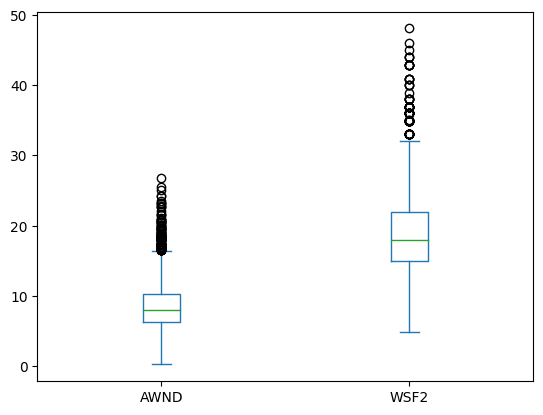

In [28]:
weather[['AWND','WSF2']].plot(kind='box')
plt.show()

Notice that the minimum values are above zero, and the fastest wind speed values are greater than the average wind speed values. Also, the numbers seem reasonable given that they are measured in miles per hour. These are all simple signs that the data is trustworthy.

It would also be useful to validate that the fastest wind speed values are greater than the average values for every single row. We'll do this by subtracting the average speed from the fastest speed and storing the results in a new column.

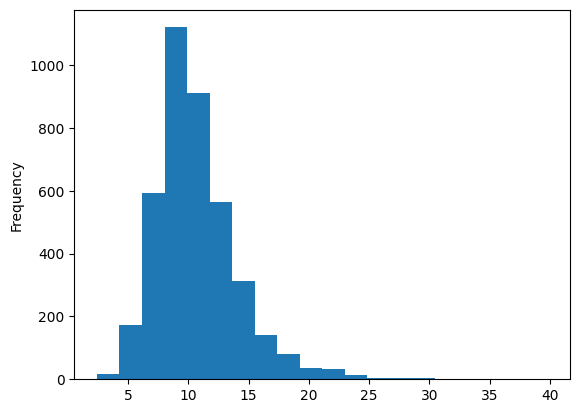

In [29]:
weather['WDIFF'] = weather.WSF2 - weather.AWND
weather.WDIFF.plot(kind='hist',bins=20)
plt.show()

There are no values below zero, which is a good sign. We can now see that the difference between the fastest and average wind speed values has an approximately normal shape. Many natural phenomena have a normal distribution, and so this shape is another sign that the dataset is trustworthy.

Let's examine the temperature columns from the weather dataset to assess whether the data seems trustworthy. 

              TMIN         TAVG         TMAX
count  4017.000000  1217.000000  4017.000000
mean     43.484441    52.493016    61.268608
std      17.020298    17.830714    18.199517
min      -5.000000     6.000000    15.000000
25%      30.000000    39.000000    47.000000
50%      44.000000    54.000000    62.000000
75%      58.000000    68.000000    77.000000
max      77.000000    86.000000   102.000000


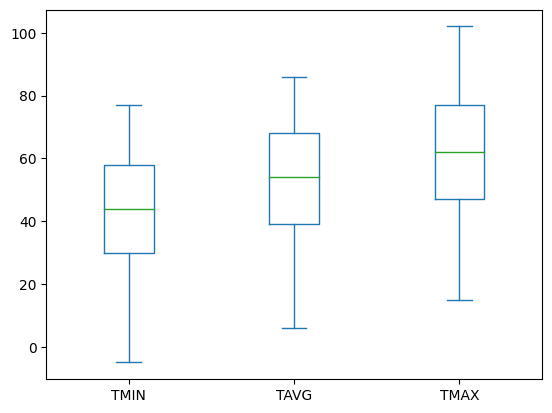

In [30]:
print(weather[['TMIN', 'TAVG', 'TMAX']].describe())

weather[['TMIN', 'TAVG', 'TMAX']].plot(kind='box')

plt.show()

The temperature data looks good so far: the TAVG values are in between TMIN and TMAX, and the measurements and ranges seem reasonable.

count    4017.000000
mean       17.784167
std         6.350720
min         2.000000
25%        14.000000
50%        18.000000
75%        22.000000
max        43.000000
Name: TDIFF, dtype: float64


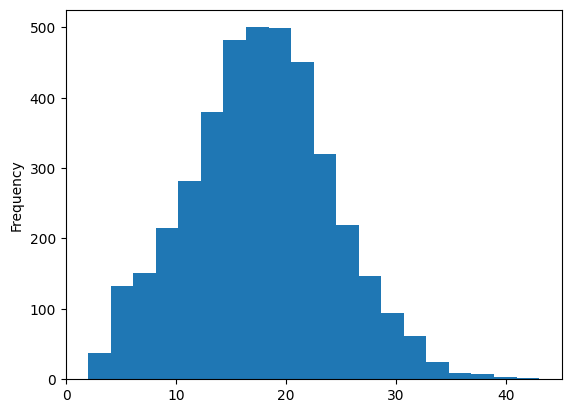

In [31]:
weather['TDIFF'] = weather.TMAX - weather.TMIN

print(weather['TDIFF'].describe())

weather['TDIFF'].plot(kind='hist',bins=20)

plt.show()

The TDIFF column has no negative values and its distribution is approximately normal, both of which are signs that the data is trustworthy.

### Categorizing the weather

The weather DataFrame contains 20 columns that start with 'WT', each of which represents a bad weather condition. For example:

WT05 indicates "Hail"

WT11 indicates "High or damaging winds"

WT17 indicates "Freezing rain"

For every row in the dataset, each WT column contains either a 1 (meaning the condition was present that day) or NaN (meaning the condition was not present).

Now we'll quantify "how bad" the weather was each day by counting the number of 1 values in each row.

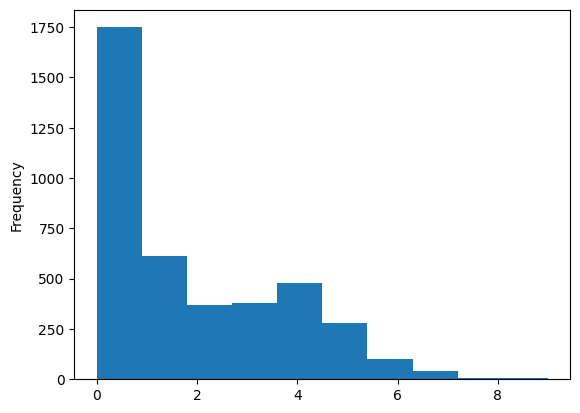

In [32]:
WT = weather.loc[:,'WT01':'WT22']

weather['bad_conditions'] = WT.sum(axis='columns')

weather['bad_conditions'] = weather.bad_conditions.fillna(0).astype('int')

weather['bad_conditions'].plot(kind='hist')

plt.show()

It looks like many days didn't have any bad weather conditions, and only a small portion of days had more than four bad weather conditions.

Now we'll use the counts to create a rating system for the weather.

The counts range from 0 to 9, and should be converted to ratings as follows:

Convert 0 to 'good'

Convert 1 through 4 to 'bad'

Convert 5 through 9 to 'worse'


In [33]:
print(weather.bad_conditions.value_counts().sort_index())

mapping = {0:'good', 1:'bad', 2:'bad', 3:'bad', 4:'bad', 5:'worse', 6:'worse', 7:'worse', 8:'worse', 9:'worse',}

weather['rating'] = weather.bad_conditions.map(mapping)

print(weather.rating.value_counts())

0    1749
1     613
2     367
3     380
4     476
5     282
6     101
7      41
8       4
9       4
Name: bad_conditions, dtype: int64
bad      1836
good     1749
worse     432
Name: rating, dtype: int64


Since the rating column only has a few possible values, we'll change its data type to category in order to store the data more efficiently. We'll also specify a logical order for the categories, which will be useful later

In [34]:
cats = pd.CategoricalDtype(['good','bad','worse'], ordered=True)

weather['rating'] = weather.rating.astype(cats)

print(weather['rating'].head())

0    bad
1    bad
2    bad
3    bad
4    bad
Name: rating, dtype: category
Categories (3, object): ['good' < 'bad' < 'worse']


### Merging datasets

In [35]:
police.reset_index(inplace=True)

print(police.head())

weather_rating=weather.loc[:,['DATE','rating']]

print(weather_rating.head())

        stop_datetime   stop_date stop_time  ... district  frisk stop_minutes
0 2005-01-04 12:55:00  2005-01-04     12:55  ...  Zone X4  False            8
1 2005-01-23 23:15:00  2005-01-23     23:15  ...  Zone K3  False            8
2 2005-02-17 04:15:00  2005-02-17     04:15  ...  Zone X4  False            8
3 2005-02-20 17:15:00  2005-02-20     17:15  ...  Zone X1  False           23
4 2005-02-24 01:20:00  2005-02-24     01:20  ...  Zone X3  False            8

[5 rows x 16 columns]
         DATE rating
0  2005-01-01    bad
1  2005-01-02    bad
2  2005-01-03    bad
3  2005-01-04    bad
4  2005-01-05    bad


In [36]:
print(police.shape)

police_weather = pd.merge(left=police, right=weather_rating, left_on='stop_date', right_on='DATE', how='left')

print(police_weather.shape)

police_weather.set_index('stop_datetime', inplace=True)

(86536, 16)
(86536, 18)


### Does weather affect the arrest rate?

First, We'll calculate the overall arrest rate.

Then, We'll calculate the arrest rate for each of the weather ratings you previously assigned.

Finally, We'll add violation type as a second factor in the analysis, to see if that accounts for any differences in the arrest rate.

In [37]:
print("Overall arrest rate is: ",police_weather.is_arrested.mean())

Overall arrest rate is:  0.0355690117407784


In [39]:
print("Arrest rate for each rating is: ")
print(police_weather.groupby('rating').is_arrested.mean())

Arrest rate for each rating is: 
rating
good     0.033715
bad      0.036261
worse    0.041667
Name: is_arrested, dtype: float64


In [40]:
print(police_weather.groupby(['violation','rating']).is_arrested.mean())

violation            rating
Equipment            good      0.059007
                     bad       0.066311
                     worse     0.097357
Moving violation     good      0.056227
                     bad       0.058050
                     worse     0.065860
Other                good      0.076966
                     bad       0.087443
                     worse     0.062893
Registration/plates  good      0.081574
                     bad       0.098160
                     worse     0.115625
Seat belt            good      0.028587
                     bad       0.022493
                     worse     0.000000
Speeding             good      0.013405
                     bad       0.013314
                     worse     0.016886
Name: is_arrested, dtype: float64


The arrest rate increases as the weather gets worse, and that trend persists across many of the violation types. This doesn't prove a causal link, but it's quite an interesting result!